# **Foor Review sentiment analysis**

**Deployed web app :** https://praathapj-foodreviewsentimentana-foodreviewsentiment-app-e1nreg.streamlit.app/

# **Business Problem**

A food product will have multiple reviews from multiple websites with rating or without rating but only text. As a product owner I want to understand the count or percentage of total Positive, Neutral and Negative reviews for the product.

This can be made accessable with online tools which can analyze hundreds of reviews and analyze the sentiment(Positive/Neutral/Negative) 

# **Business objective and constraints**
* Interpretablity is partially important.
* No low latency requirement( couple of seconds to minutes is acceptable)
* Errors -> classification if all the class is equally important.

# **Mapping to an ML problem**

## Data aquisation from kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp /content/drive/MyDrive/DS_DL_ML_AI_project/kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d snap/amazon-fine-food-reviews

 93% 225M/242M [00:02<00:00, 126MB/s]
100% 242M/242M [00:02<00:00, 103MB/s]


In [ ]:
! mkdir train

In [ ]:
# All the data in the ZIP will be unzipped in train folder.
! unzip /content/amazon-fine-food-reviews.zip -d train

Archive:  /content/amazon-fine-food-reviews.zip
  inflating: train/Reviews.csv       
  inflating: train/database.sqlite   
  inflating: train/hashes.txt        


## **Data Files Overview**
**Amazon Fine Food Reviews Analysis**


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### ML Objective:

To determine whether the review is Positive, Negative or Neutral by predicting the rating using only the text features and classify into:
* Positive( Rating of 4 or 5)
* Neutral( Rating of 3)
* Negative( Rating of 2 or 1)

This is an approximate and proxy way of determining the polarity (positive/neutral/negative) of a review.

## ML Problem

* Multi class classification problem.
* Sentiment analysis only with text features.
* Precision and Recall both are equally important.

## Performance Metric

* Cross Entropy or multi class log-loss.
* Confusion matrics

##Train Test Split

* Random split as there is no time stamps in the data.
* Split with stratify since classification problem.

# Data Loading, Cleaning and Prepration

## Import Libraries

In [ ]:
import nltk
nltk.download('punkt')
import sqlite3
import pandas as pd
from sklearn.model_selection import train_test_split
import regex as re
from bs4 import BeautifulSoup
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import pickle
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample # To oversamle and under sample
from scipy.sparse import csr_matrix
from sklearn.metrics import log_loss
from sklearn.model_selection import RepeatedStratifiedKFold # To stratify split for kfold
from sklearn.preprocessing import MaxAbsScaler
from prettytable import PrettyTable

## Read/Load Data

In [ ]:
# There are 2 file format, SQL and CSV
# Since the data is huge reading the SQL file
sqlConn = sqlite3.connect("/content/train/database.sqlite")

reviewsData = pd.read_sql_query(
    """
    SELECT *
    FROM Reviews
    LIMIT 155000
    """, sqlConn)

print("Shape of reviews data",reviewsData.shape)
reviewsData.head()

Shape of reviews data (155000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Ceaning and Handling Missing vlues

In [ ]:
reviewsData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155000 entries, 0 to 154999
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      155000 non-null  int64 
 1   ProductId               155000 non-null  object
 2   UserId                  155000 non-null  object
 3   ProfileName             155000 non-null  object
 4   HelpfulnessNumerator    155000 non-null  int64 
 5   HelpfulnessDenominator  155000 non-null  int64 
 6   Score                   155000 non-null  int64 
 7   Time                    155000 non-null  int64 
 8   Summary                 155000 non-null  object
 9   Text                    155000 non-null  object
dtypes: int64(5), object(5)
memory usage: 11.8+ MB


* Helpfulness Numerator, Denominator, Score, are int Dtype and do not have nether standard or non standard null values.
* Ignoreing ID's and Time
* Sumarry and Text are object hence should check for non standard null values like <>, ?, -- etc.

**Checking for non stanard null values and converting them to nan**

In [ ]:
# Checking for possible vague summary 
[i for i in reviewsData['Summary'] if len(i) <= 3][:10]

['Bad', 'WOW', 'Wow', 'Yum', 'Meh', 'yum', 'K', 'Ok', 'Yum', 'A+']

* Summary with 3 letter word's are fine but 2 letter words are vague.

In [ ]:
# Analyzng 2 letter words
[i for i in reviewsData['Summary'] if len(i) <= 2][:10]

['K', 'Ok', 'A+', 'nt', 'JZ', 'ok', 'Mr', 'JV', 'OK', 'OK']

* Variations of 'ok' has meaning and needs to be converted but but rest needs to be removed.
* At preprocessing stage these words will be removed.

In [ ]:
# Possible 2 letter words with meaning obtained manually from dataset
nonVague = ['OK','ok','Ok','oK']


In [ ]:
# Check vague review in 'Text'
[i for i in reviewsData['Text'] if len(i) <= 4][:10]

[]

* No non vague reviews in Text

In [ ]:
# Summarizing Missing Values

reviewsData.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

* No standard or non standard null values

In [ ]:
# Checking for duplicate review for same used ID and product ID

# One product can have good or bad reviews, so there can be duplicate product ID but 
# For same product one user can have only one review, hence remove the duplicates in combination
# Considering last review of the user for the same product to be latest is not duplicate, keeping the last duplicate review and dropping the rest.

print("Data shape before duplicates",reviewsData.shape)
print("-"*50)

reviewsData.drop_duplicates(subset=['ProductId','UserId'],keep='last', inplace=True)
print("Data size post dropping duplicates",reviewsData.shape)

Data shape before duplicates (155000, 10)
--------------------------------------------------
Data size post dropping duplicates (152752, 10)


In [ ]:
# 'HelpfulnessNumerator' -> Number of people found the review helpful out of "HelpfulnessDenominator"
# 'HelpfulnessNumerator' cannot be greater then 'HelpfulnessDenominator' hence drop the rows with incorrect data

incHelpIndx = reviewsData[reviewsData['HelpfulnessNumerator'] > reviewsData['HelpfulnessDenominator']].index
reviewsData.drop(index=incHelpIndx, axis=0, inplace=True)
reviewsData.shape

(152750, 10)

In [ ]:
# Analyzing unique scores to check for ambiguity

reviewsData['Score'].unique()

array([5, 1, 4, 2, 3])

In [ ]:
# Clreating new column by combining both text and summary

reviewsData['final_review'] = reviewsData['Summary']+" "+reviewsData['Text']
reviewsData.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,final_review
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Good Quality Dog Food I have bought several of...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised Product arrived labeled as J...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,"""Delight"" says it all This is a confection tha..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,Cough Medicine If you are looking for the secr...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,Great taffy Great taffy at a great price. The...


## Text Pre Processing

In [ ]:
# Analyze few random text

for i in range(0,10):
  print("Review",(i*i),"->",reviewsData['final_review'][i*i])
  print("-"*len(reviewsData['Text'][i*i]))

Review 0 -> Good Quality Dog Food I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Review 1 -> Not as Advertised Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Review 4 -> Great taffy Gr

**Observation**
* Above sample sentence has html tags, urls, stop words etc
* **In the 'Text' feature preprocessing stage we will following the order below:-**
* Begin by removing the html tags
*Remove any punctuations or limited set of special characters like , or . or # etc.
*Check if the word is made up of english letters and is not alpha-numeric
*Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
*Convert the word to lowercase
*Remove Stopwords
*Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)

In [ ]:
# remove url https://stackoverflow.com/a/40823105/4084039

# eg for review 25

url_removal = re.sub(r"http\S+", "", reviewsData.Text[25])
url_removal

'Product received is as advertised.<br /><br /><a href=" Strawberry, 16-Ounce Bags (Pack of 6)</a>'

In [ ]:
# Remove html tags

# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element

# eg for review 36

soup = BeautifulSoup(reviewsData.Text[36], "html.parser")
html_remove = soup.get_text()
html_remove

"For those of us with celiac disease this product is a lifesaver and what could be better than getting it at almost half the price of the grocery or health food store!  I love McCann's instant oatmeal - all flavors!!!Thanks,Abby"

In [ ]:
# De contract the sentence eg: won't -> will not etc

# https://stackoverflow.com/a/47091490/4084039

# For eg review 36

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

decontracted(reviewsData.Text[36])

'For those of us with celiac disease this product is a lifesaver and what could be better than getting it at almost half the price of the grocery or health food store!  I love McCann is instant oatmeal - all flavors!!!<br /><br />Thanks,<br />Abby'

In [ ]:
# Remove alphanumeric https://stackoverflow.com/a/18082370/4084039
# eg with review 25

alphaNUm_remove = re.sub("\S*\d\S*", "", reviewsData.Text[25]).strip()
print(alphaNUm_remove)

Product received is as advertised.<br /><br /><a  Strawberry,  Bags (Pack of


In [ ]:
#remove spacial character https://stackoverflow.com/a/5843547/4084039

secial_char_remove = re.sub('[^A-Za-z0-9]+', ' ', reviewsData.Text[1])
print(secial_char_remove)

Product arrived labeled as Jumbo Salted Peanuts the peanuts were actually small sized unsalted Not sure if this was an error or if the vendor intended to represent the product as Jumbo 


In [ ]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [ ]:
# It's suggested to perform stemming for sentement analysis and lematization for Chatbot
# Performing stemming on preprocessed text feature: https://www.analyticsvidhya.com/blog/2021/11/an-introduction-to-stemming-in-natural-language-processing/


def stemming(text):
    snowball = SnowballStemmer(language='english')
    store_list=[]
    for token in word_tokenize(text):
        store_list.append(snowball.stem(token))
    return ' '.join(store_list)

def preprocess_review(text,stopwords):
  # Combining all the above stundents 
  preprocessed_text = []
  # tqdm is for printing the status bar
  for sentance in tqdm(text):
      sentance = re.sub(r"http\S+", "", sentance)
      sentance = BeautifulSoup(sentance,"html.parser").get_text()
      sentance = decontracted(sentance)
      sentance = re.sub("\S*\d\S*", "", sentance).strip()
      sentance = re.sub('[^A-Za-z]+', ' ', sentance)
      
      # https://gist.github.com/sebleier/554280
      temp_sent = ()
      for e in sentance.split():
          if e.lower() == "ok":
            temp_sent += ("okay",)
          elif (e.lower() not in stopwords) & (len(e)>2):
            temp_sent += (e.lower(),)
      sentence = " ".join(temp_sent)
      # Stemming 
      preprocessed_text.append(stemming(sentence.strip()))
  
  return preprocessed_text

preprocessText = preprocess_review(reviewsData['final_review'].values,stopwords)

# Eg:
preprocessText[:5]

  0%|          | 76/152750 [00:00<12:04, 210.60it/s]<ipython-input-29-5e8a923834de>:18: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  sentance = BeautifulSoup(sentance,"html.parser").get_text()
100%|██████████| 152750/152750 [04:41<00:00, 542.02it/s]


['good qualiti dog food bought sever vital can dog food product found good qualiti product look like stew process meat smell better labrador finicki appreci product better',
 'not advertis product arriv label jumbo salt peanut peanut actual small size unsalt not sure error vendor intend repres product jumbo',
 'delight say confect around centuri light pillowi citrus gelatin nut case filbert cut tini squar liber coat powder sugar tini mouth heaven not chewi flavor high recommend yummi treat familiar stori lewi lion witch wardrob treat seduc edmund sell brother sister witch',
 'cough medicin look secret ingredi robitussin believ found got addit root beer extract order good made cherri soda flavor medicin',
 'great taffi great taffi great price wide assort yummi taffi deliveri quick taffi lover deal']

In [ ]:
reviewsData['finalPreprocessReview'] = np.asarray(preprocessText)
reviewsData.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,final_review,finalPreprocessReview
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Good Quality Dog Food I have bought several of...,good qualiti dog food bought sever vital can d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised Product arrived labeled as J...,not advertis product arriv label jumbo salt pe...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,"""Delight"" says it all This is a confection tha...",delight say confect around centuri light pillo...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,Cough Medicine If you are looking for the secr...,cough medicin look secret ingredi robitussin b...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,Great taffy Great taffy at a great price. The...,great taffi great taffi great price wide assor...


## score preprocessing

In [ ]:
# There are 5 class, need to convert them to 3

In [ ]:
# Edit target variable, we have 5 labels i.e 1 to 5.
# but require 3 labels 0-> Negative, 1-> Neutral, 2-> Positive

def target_mod(y):
  if y in [5,4]:
    return 2
  elif y == 3:
    return 1
  else:
    return 0

# Mapping sentiment values to target
reviewsData['sentiment'] = reviewsData.Score.map(target_mod)
reviewsData.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,final_review,finalPreprocessReview,sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Good Quality Dog Food I have bought several of...,good qualiti dog food bought sever vital can d...,2
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised Product arrived labeled as J...,not advertis product arriv label jumbo salt pe...,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,"""Delight"" says it all This is a confection tha...",delight say confect around centuri light pillo...,2


In [ ]:
# Cleaned reviews data export as CSV
reviewsData.to_csv("/content/drive/MyDrive/DS_DL_ML_AI_project/Sentiment Analysis/preprocessed_reviewsData.csv",index=False)

reviewsData = pd.read_csv("/content/drive/MyDrive/DS_DL_ML_AI_project/Sentiment Analysis/preprocessed_reviewsData.csv")
reviewsData.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,final_review,finalPreprocessReview,sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Good Quality Dog Food I have bought several of...,good qualiti dog food bought sever vital can d...,2
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised Product arrived labeled as J...,not advertis product arriv label jumbo salt pe...,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,"""Delight"" says it all This is a confection tha...",delight say confect around centuri light pillo...,2


# Data analysis
* Analysing features related to text data since the model predicts sentiment with respect to text

<Axes: xlabel='sentiment', ylabel='count'>

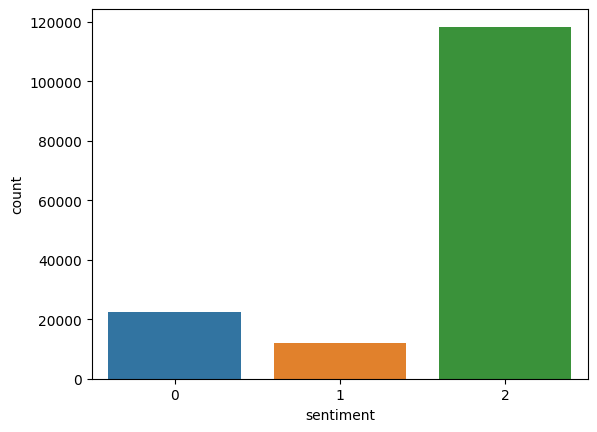

In [ ]:
# Distribution of rating 

sns.countplot(x=reviewsData['sentiment'])

In [ ]:
# Analyze the class counts

reviewsData['sentiment'].value_counts()

2    118351
0     22408
1     11991
Name: sentiment, dtype: int64

In [ ]:
# Both over sampling and under sampling to balance the data.
median_class_count = int(reviewsData['sentiment'].value_counts().median())
print("median sample count of all he class distribution:",median_class_count)

median sample count of all he class distribution: 22408


**Observation**
* Highly imbalance data.
* Balance the data at 'median_class_count' observation for all the class

In [ ]:
# Word cloud by Frequency of Words in our corpus.

def word_cloud_gen(dataframe,category):
    #Creating the text variable
    text = " ".join(review for review in dataframe[dataframe['sentiment'] == category]['finalPreprocessReview'])
    # Creating word_cloud with text as argument in .generate() method
    word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)
    # Display the generated Word Cloud
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis("off")
    if category == 2:
      print("\n   Word cloud for {} rating".format("Positive"))
    elif category == 1:
      print("\n   Word cloud for {} rating".format("Neutral"))
    else:
      print("\n   Word cloud for {} rating".format("Negative"))
    return plt.show()



   Word cloud for Positive rating


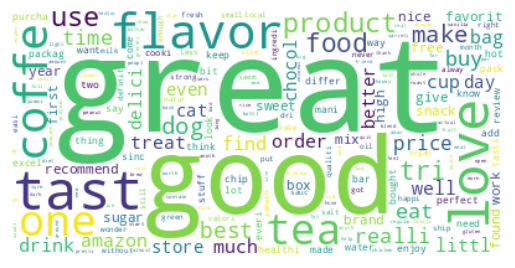


   Word cloud for Neutral rating


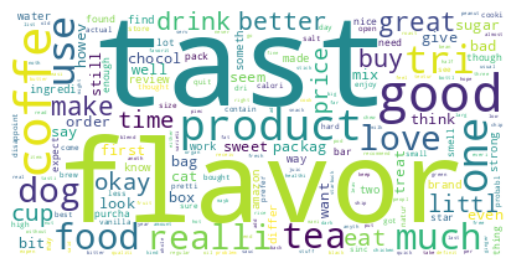


   Word cloud for Negative rating


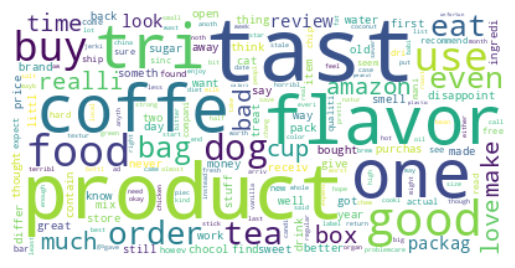

In [ ]:
word_cloud_gen(reviewsData,2)
word_cloud_gen(reviewsData,1)
word_cloud_gen(reviewsData,0)

**Observation**
* For positive rating highest word freq are best, love and followed by good
* Neutral rating ->  highest word freq are Ok and good.
* Negative rating -> along with taste and good we can seen bad, disappointed etc.

In [ ]:
# Drop basic non usefull columns
reviewsData.drop(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator','Time', 'Summary', 'Text',
       'final_review', "Score"], axis = 1, inplace=True)
reviewsData.head(3)

,finalPreprocessReview,sentiment
0,good qualiti dog food bought sever vital can d...,2
1,not advertis product arriv label jumbo salt pe...,0
2,delight say confect around centuri light pillo...,2


# Train Test Split

In [ ]:
X = reviewsData['finalPreprocessReview'].copy()
y = reviewsData['sentiment'].copy()

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=35, stratify=y)
print("Shape of train X:",X_train.shape,"y:",y_train.shape)
print("Shape of test X:", X_test.shape,"y:",y_test.shape)

Shape of train X: (106925,) y: (106925,)
Shape of test X: (45825,) y: (45825,)


# Data balancing
* Sampling only the train data

In [ ]:
# Resampling (Oversampling and Undersampling)
#create two different dataframe of majority and minority class 

posInd = y_train[y_train == 2].index
posReview = X_train.loc[posInd]

neuInd = y_train[y_train == 1].index
neuReview = X_train.loc[neuInd]

negInd = y_train[y_train == 0].index
negReview = X_train.loc[negInd]

In [ ]:
# Positive review samples 

posSamp  = resample(posReview,
                    replace=False,    # sample with replacement
                    n_samples= median_class_count, # to match majority class undersample majority class
                    random_state=35)

posSamp.shape

(22408,)

In [ ]:
# Neutral review samples

neuSamp = resample(neuReview,replace=True,n_samples= median_class_count, random_state=35)
neuSamp.shape

(22408,)

In [ ]:
# Negative review samples
negSamp = resample(negReview,replace=True,n_samples= median_class_count, random_state=35)
negSamp.shape

(22408,)

In [ ]:
# concat and make new target variable
y_pos = np.full(median_class_count,2)
y_neu = np.full(median_class_count,1)
y_neg = np.full(median_class_count,0)

In [ ]:
# Combine balanced class
X_tr_bal = pd.concat([posSamp, neuSamp,negSamp])
y_tr_bal = pd.concat([pd.Series(y_pos), pd.Series(y_neu),pd.Series(y_neg)])

In [ ]:
# Shape of train
print("Shape of train X:",X_tr_bal.shape,"y:",y_tr_bal.shape)

Shape of train X: (67224,) y: (67224,)


# Featurization of Text data

**BAG OF WORDS [BOW]**
* Does not consider flow of sentence or meaning.
* Useful for basic and quick text featurize and analysis.

In [ ]:
# BOW count on final pre-processed features

print("Before 'BOW count vectorization'")
print("shape of X train:",X_tr_bal.shape, ", y train:", y_tr_bal.shape)
print("shape of X test:",X_test.shape, ", y test:", y_test.shape)

print("-"*60)

# Words are already in lower case
count_vect = CountVectorizer(lowercase=False,min_df=10,max_features=5000) 
count_vect.fit(X_tr_bal.values) # fit has to happen only on train data and there is only one feature

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = count_vect.transform(X_tr_bal.values)
X_test_bow = count_vect.transform(X_test.values)

print("After 'BOW count vectorization'")
print("shape of X train:",X_train_bow.shape, ", y train:", y_tr_bal.shape)
print("shape of X test:",X_test_bow.shape, ", y test:", y_test.shape)
print("-"*60)

Before 'BOW count vectorization'
shape of X train: (67224,) , y train: (67224,)
shape of X test: (45825,) , y test: (45825,)
------------------------------------------------------------
After 'BOW count vectorization'
shape of X train: (67224, 5000) , y train: (67224,)
shape of X test: (45825, 5000) , y test: (45825,)
------------------------------------------------------------


In [ ]:
# Normalizing BOW data

norm = MaxAbsScaler()
X_tr_bow_norm = norm.fit_transform(X_train_bow)
X_te_bow_norm = norm.transform(X_test_bow)

**Bi-Grams and n-Grams BOW**
* similar to previous count vectorizer but has 1 word count and 2 or more words combined count.

In [ ]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams

print("Before 'BOW n-gram count vectorization'")
print("shape of X train:",X_tr_bal.shape, ", y train:", y_tr_bal.shape)
print("shape of X test:",X_test.shape, ", y test:", y_test.shape)

print("-"*60)

# Words are already in lower case
count_vect_ngram = CountVectorizer(lowercase=False,ngram_range=(1,3),min_df=10,max_features=5000) 
count_vect_ngram.fit(X_tr_bal.values) # fit has to happen only on train data and there is only one feature

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow_ngram = count_vect_ngram.transform(X_tr_bal.values)
X_test_bow_ngram = count_vect_ngram.transform(X_test.values)

print("After 'BOW n-gram count vectorization'")
print("shape of X train:",X_train_bow_ngram.shape, ", y train:", y_tr_bal.shape)
print("shape of X test:",X_test_bow_ngram.shape, ", y test:", y_test.shape)
print("-"*60)

Before 'BOW n-gram count vectorization'
shape of X train: (67224,) , y train: (67224,)
shape of X test: (45825,) , y test: (45825,)
------------------------------------------------------------
After 'BOW n-gram count vectorization'
shape of X train: (67224, 5000) , y train: (67224,)
shape of X test: (45825, 5000) , y test: (45825,)
------------------------------------------------------------


In [ ]:
# Normalizing BOW ngram data

norm = MaxAbsScaler()
X_tr_bow_ngram_norm = norm.fit_transform(X_train_bow_ngram)
X_te_bow_ngram_norm = norm.transform(X_test_bow_ngram)

**Binary BOW**
* vectorized data has only 1's-> word fount or 0's -> word not fount.

In [ ]:
# BOW Binary on final pre-processed features

print("Before 'BOW Binary vectorization'")
print("shape of X train:",X_tr_bal.shape, ", y train:", y_tr_bal.shape)
print("shape of X test:",X_test.shape, ", y test:", y_test.shape)

print("-"*60)

# Words are already in lower case
count_vect_binary = CountVectorizer(lowercase=False,min_df=10,max_features=5000, binary=True) 
count_vect_binary.fit(X_tr_bal.values) # fit has to happen only on train data and there is only one feature

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow_binary = count_vect_binary.transform(X_tr_bal.values)
X_test_bow_binary = count_vect_binary.transform(X_test.values)

print("After 'BOW Binary vectorization'")
print("shape of X train:",X_train_bow_binary.shape, ", y train:", y_tr_bal.shape)
print("shape of X test:",X_test_bow_binary.shape, ", y test:", y_test.shape)
print("-"*60)

Before 'BOW Binary vectorization'
shape of X train: (67224,) , y train: (67224,)
shape of X test: (45825,) , y test: (45825,)
------------------------------------------------------------
After 'BOW Binary vectorization'
shape of X train: (67224, 5000) , y train: (67224,)
shape of X test: (45825, 5000) , y test: (45825,)
------------------------------------------------------------


**TF-IDF**
* Term Frequency * Inverse Document Frequence
* Known to work well for Sentiment Analysis.

In [ ]:
# TF-IDF count on final pre-processed features.

print("Before 'TF-IDF vectorization'")
print("shape of X train:",X_tr_bal.shape, ", y train:", y_tr_bal.shape)
print("shape of X test:",X_test.shape, ", y test:", y_test.shape)

print("-"*60)

# Words are already in lower case
tf_idf_vect = TfidfVectorizer(lowercase=False,ngram_range=(1,2), min_df=10,max_features=5000) 
tf_idf_vect.fit(X_tr_bal.values) # fit has to happen only on train data and there is only one feature

# we use the fitted CountVectorizer to convert the text to vector
X_train_tf_idf = tf_idf_vect.transform(X_tr_bal.values)
X_test_tf_idf = tf_idf_vect.transform(X_test.values)

print("After 'Tf-Idf vectorization'")
print("shape of X train:",X_train_tf_idf.shape, ", y train:", y_tr_bal.shape)
print("shape of X test:",X_test_tf_idf.shape, ", y test:", y_test.shape)
print("-"*60)

Before 'TF-IDF vectorization'
shape of X train: (67224,) , y train: (67224,)
shape of X test: (45825,) , y test: (45825,)
------------------------------------------------------------
After 'Tf-Idf vectorization'
shape of X train: (67224, 5000) , y train: (67224,)
shape of X test: (45825, 5000) , y test: (45825,)
------------------------------------------------------------


In [ ]:
# Normalizing TFIDF data

tfIdf_norm = MaxAbsScaler()
X_tr_tf_idf_norm = tfIdf_norm.fit_transform(X_train_tf_idf)
X_te_tf_idf_norm = tfIdf_norm.transform(X_test_tf_idf)

**Word2Vec**
* Using pretrained word2Vec data

In [ ]:
#please use below code to load glove vectors from your glove file path
# 300 dim glove file obtained from https://nlp.stanford.edu/projects/glove/

with open('/content/drive/MyDrive/DS_DL_ML_AI_project/Sentiment Analysis/glove_vectors', 'rb') as f:
    glove_model = pickle.load(f) # vectors 
    glove_words =  set(glove_model.keys()) # Set of words of all vectors

In [ ]:
#perform w2v(GloVe) vectorization of text data.

def Glove_w2v(data,glove_vect, glove_wrd):  
  '''retunrs 300 dim GloVe word 2 vector for a given review.

  data: sentences to be converted.
  glove: words or dict key from glove file.
  '''
  # Convert 'reviews' into list of reviews
  list_of_reviews = []
  for review in data:
    list_of_reviews.append(review.split())

  glove_sent_vec = [] #the w2v(glove) for each review is stored in the list


  for review in tqdm(list_of_reviews):
    review_vec = np.zeros(300) # as word vectors are of zero length
    for word in review: # for each word in a review/sentence
      if word in glove_wrd:
        vector = glove_vect[word]
        review_vec +=  vector

    glove_sent_vec.append(review_vec)
  return glove_sent_vec

In [ ]:
# feature words from tfidf words
tfidf_features = count_vect.get_feature_names_out() 

#W2V GloVe is already trained on large set of words hence not required fit, transform.
# here we fetch the w2v values for each word and compute.
X_train_w2v = Glove_w2v(X_tr_bal.values,glove_model,glove_words)
X_test_w2v = Glove_w2v(X_test.values,glove_model,glove_words)

100%|██████████| 45825/45825 [00:02<00:00, 15710.55it/s]


In [ ]:
# Normalizing W2V  data

norm = MinMaxScaler()
X_tr_w2v_norm = norm.fit_transform(X_train_w2v)
X_te_w2v_norm = norm.transform(X_test_w2v)

**Avg Word2Vec**
* Using pretrained word2Vec data

In [ ]:
#perform avg w2v(GloVe) vectorization of text data.

def avg_Glove_w2v(data,glove_vect, glove_wrd):  
  '''retunrs 300 dim GloVe word 2 vector for a given review.

  data: sentences to be converted.
  glove: words or dict key from glove file.
  '''
  # Convert 'reviews' into list of reviews
  list_of_reviews = []
  for review in data:
    list_of_reviews.append(review.split())


  avg_glove_sent_vec = [] #the avg w2v(glove) for each review is stored in the list


  for review in tqdm(list_of_reviews):
    review_vec = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # to count num of words with a valid vector in the sentence/review
    for word in review: # for each word in a review/sentence
      if word in glove_wrd:
        vector = glove_vect[word]
        review_vec +=  vector
        cnt_words += 1
    if cnt_words != 0:
      avg_review_vec = review_vec / cnt_words
    avg_glove_sent_vec.append(avg_review_vec)
  return avg_glove_sent_vec

In [ ]:
#W2V GloVe is already trained on large set of words hence not required fit, transform.
# here we fetch the w2v values for each word and compute the avg by dividing the count.
X_train_avg_w2v = avg_Glove_w2v(X_tr_bal.values,glove_model,glove_words)
X_test_avg_w2v = avg_Glove_w2v(X_test.values,glove_model,glove_words)

100%|██████████| 45825/45825 [00:03<00:00, 14051.43it/s]


In [ ]:
# Normalizing BOW ngram data

norm = MinMaxScaler()
X_tr_avg_w2v_norm = norm.fit_transform(X_train_avg_w2v)
X_te_avg_w2v_norm = norm.transform(X_test_avg_w2v)

**TFIDF weighted W2v**

In [ ]:
# tfidf w2v(GloVe) vectorization of text data.

def tfidf_Glove_w2v(data,glove_vect,glove_wrd,idf,tfidf):  
  '''retunrs 300 dim tfidf weighted GloVe word 2 vector for a given sentence.

  data: sentences to be converted.
  glove: words or dict key from glove file.
  idf: dictonary with word as 'Key' and IDF as values from tfidf vectorizer.
  tfidf: words or column names or dict key.
  '''
  # Convert 'reviews' into list of reviews
  list_of_reviews = []
  for review in data:
    list_of_reviews.append(review.split())


  tfidf_glove_sent_vec = [] #the tfidf_w2v(glove) for each sentence is stored in the list


  for review in tqdm(list_of_reviews):
    review_vec = np.zeros(300) # as word vectors are of zero length
    weight_sum = 0 # total sum of tfidf[word] with a valid vector in the sentence/review
    for word in review: # for each word in a review/sentence
      if word in tfidf and word in glove_wrd:
        tf_idf = idf[word]*(review.count(word)/len(review))
        vector = glove_vect[word]
        review_vec += tf_idf * vector
        weight_sum += tf_idf

    if weight_sum != 0:
      review_vec /= weight_sum
    tfidf_glove_sent_vec.append(review_vec)

  return tfidf_glove_sent_vec

In [ ]:
# we are creating a dictonary with word as 'Key' and IDF as values from tfidf vectorizer
idf_dict = dict(zip(tf_idf_vect.get_feature_names_out(),list(tf_idf_vect.idf_)))

features_name = tf_idf_vect.get_feature_names_out() # words or column names or dict key.

#W2V GloVe is already trained on large set of words hence not required fit, transform.
# here we fetch the w2v values for each word and compute weighted tfidf.
X_train_tfidf_w2v = tfidf_Glove_w2v(X_tr_bal.values,glove_model,glove_words,idf_dict,features_name)
X_test_tfidf_w2v = tfidf_Glove_w2v(X_test.values,glove_model,glove_words,idf_dict,features_name)

100%|██████████| 45825/45825 [06:22<00:00, 119.85it/s]


In [ ]:
# Normalizing BOW ngram data

norm = MinMaxScaler()
X_tr_tfidf_w2v_norm = norm.fit_transform(X_train_tfidf_w2v)
X_te_tfidf_w2v_norm = norm.transform(X_test_tfidf_w2v)

# Predective Modelling

## Random model

* Understanding the highest possible loss by calculating the loss for random prediction.

In [ ]:
#Source: https://towardsdatascience.com/estimate-model-performance-with-log-loss-like-a-pro-9f47d13c8865

def random_log_loss(class_ratio,multi):
    """
    Calculate the class ratios-> ratios of appearing cllass in y_test 
    which should sum up to 1

    multi: number of observation
    
    returns:
    actuals: actual probablity of class appearing 1 or 0
    preds: predicted prob of class appearing based on class ratio
    """
    
    if sum(class_ratio)!=1.0:
        print("warning: Sum of ratios should be 1 for best results")
        class_ratio[-1]+=1-sum(class_ratio)  # add the residual to last class's ratio
    
    actuals=[]
    for i,val in enumerate(class_ratio):
        actuals=actuals+[i for x in range(int(val*multi))]
        

    preds=[]
    for i in range(1,multi):
        preds+=[class_ratio]

    return (log_loss(actuals, preds))

# Probablity of picking each class with respect to test data
# prob_class = class_count/total_count

randProb_pos = round(np.count_nonzero(y_test == 2)/y_test.count(),2)
randProb_neu = round(np.count_nonzero(y_test == 1)/y_test.count(),2)
randProb_neg = round(np.count_nonzero(y_test == 0)/y_test.count(),2)

randModel_logloss=random_log_loss([randProb_pos,randProb_neu,randProb_neg],y_test.count())
print("Highest log loss predicted by random model:",round(randModel_logloss,2))

Highest log loss predicted by random model: 0.69


**Observation**
* Max possible loss by random model is 0.69.
* Any trained model loss should be less than random model.

##  Multinomial NB - BOW
* The multinomial distribution normally requires integer feature counts.
*  in practice, fractional counts such as tf-idf may also work.

In [ ]:
# Perform Hyperparameter Tuning Using RandomizedSearchCV


nb = MultinomialNB(force_alpha=False,class_prior = [0.33, 0.33, 0.33])

parameters = {'alpha':[0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]}

cv_strat = RepeatedStratifiedKFold(n_splits=5,  n_repeats=3, random_state=35)

NbClfBOW = RandomizedSearchCV(nb, parameters, cv= cv_strat, return_train_score=False, random_state=35,refit=True,
                              n_jobs=-1,scoring="accuracy", n_iter=13,verbose=3)

NbClfBOW.fit(X_tr_bow_norm, y_tr_bal)

Fitting 15 folds for each of 13 candidates, totalling 195 fits


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=35),
                   estimator=MultinomialNB(class_prior=[0.33, 0.33, 0.33],
                                           force_alpha=False),
                   n_iter=13, n_jobs=-1,
                   param_distributions={'alpha': [1e-05, 0.0005, 0.0001, 0.005,
                                                  0.001, 0.05, 0.01, 0.1, 0.5,
                                                  1, 5, 10, 50, 100]},
                   random_state=35, scoring='accuracy', verbose=3)

In [ ]:
y_pred = NbClfBOW.predict_proba(X_te_bow_norm)
log_loss(y_test,y_pred)

0.7442977936739648

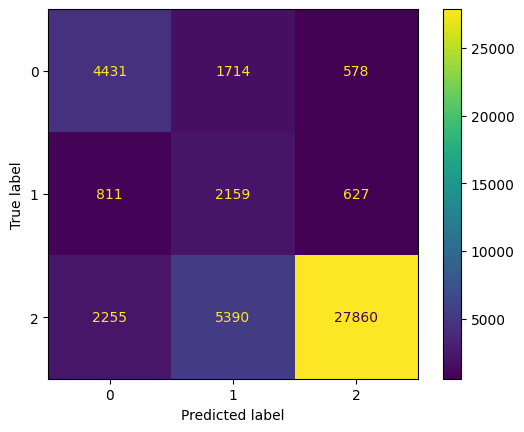

In [ ]:
predictions = NbClfBOW.predict(X_te_bow_norm)
cm = confusion_matrix(y_test, predictions, labels=NbClfBOW.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=NbClfBOW.classes_)
disp.plot()
plt.show()

##  Multinomial NB - Bi-Grams and n-Grams BOW

In [ ]:
# Perform Hyperparameter Tuning Using RandomizedSearchCV

NbClfBOWnGram = RandomizedSearchCV(nb, parameters, cv= cv_strat, return_train_score=True, random_state=35,refit=True,
                              n_jobs=-1,scoring="neg_log_loss", n_iter=13,verbose=2)

NbClfBOWnGram.fit(X_tr_bow_ngram_norm, y_tr_bal)

Fitting 15 folds for each of 13 candidates, totalling 195 fits


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=35),
                   estimator=MultinomialNB(class_prior=[0.33, 0.33, 0.33],
                                           force_alpha=False),
                   n_iter=13, n_jobs=-1,
                   param_distributions={'alpha': [1e-05, 0.0005, 0.0001, 0.005,
                                                  0.001, 0.05, 0.01, 0.1, 0.5,
                                                  1, 5, 10, 50, 100]},
                   random_state=35, return_train_score=True,
                   scoring='neg_log_loss', verbose=2)

In [ ]:
y_pred = NbClfBOWnGram.predict_proba(X_te_bow_ngram_norm)
log_loss(y_test,y_pred)

0.6367083573793066

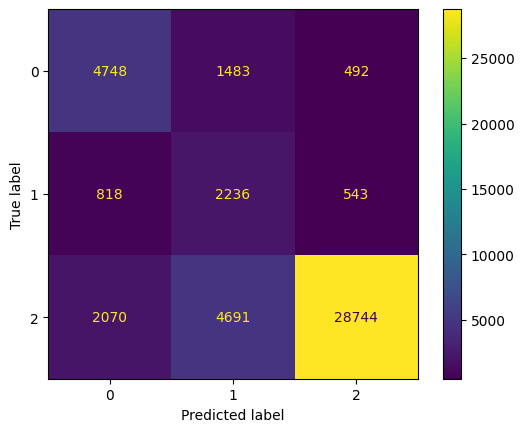

In [ ]:
predictions = NbClfBOWnGram.predict(X_te_bow_ngram_norm)
cm = confusion_matrix(y_test, predictions, labels=NbClfBOWnGram.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=NbClfBOWnGram.classes_)
disp.plot()
plt.show()

##  Multinomial Binary BOW

In [ ]:
# Perform Hyperparameter Tuning Using RandomizedSearchCV

NbClfBinaryBOW = RandomizedSearchCV(nb, parameters, cv= cv_strat, return_train_score=True, random_state=35,refit=True,
                              n_jobs=-1,scoring="neg_log_loss", n_iter=13,verbose=2)

NbClfBinaryBOW.fit(X_train_bow_binary, y_tr_bal)

Fitting 15 folds for each of 13 candidates, totalling 195 fits


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=35),
                   estimator=MultinomialNB(class_prior=[0.33, 0.33, 0.33],
                                           force_alpha=False),
                   n_iter=13, n_jobs=-1,
                   param_distributions={'alpha': [1e-05, 0.0005, 0.0001, 0.005,
                                                  0.001, 0.05, 0.01, 0.1, 0.5,
                                                  1, 5, 10, 50, 100]},
                   random_state=35, return_train_score=True,
                   scoring='neg_log_loss', verbose=2)

In [ ]:
y_pred = NbClfBinaryBOW.predict_proba(X_test_bow_binary)
log_loss(y_test,y_pred)

0.8567756438781202

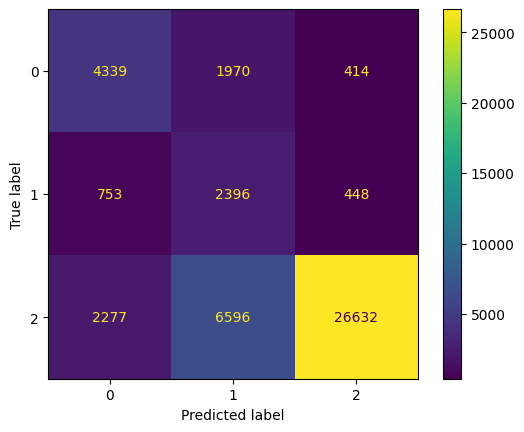

In [ ]:
predictions = NbClfBinaryBOW.predict(X_test_bow_binary)
cm = confusion_matrix(y_test, predictions, labels=NbClfBinaryBOW.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=NbClfBinaryBOW.classes_)
disp.plot()
plt.show()

##  Multinomial NB TF-IDF

In [ ]:
# Perform Hyperparameter Tuning Using RandomizedSearchCV

NbClfTfIdf = RandomizedSearchCV(nb, parameters, cv= cv_strat, return_train_score=True, random_state=35,refit=True,
                              n_jobs=-1,scoring="neg_log_loss", n_iter=13,verbose=2)

NbClfTfIdf.fit(X_tr_tf_idf_norm, y_tr_bal)

Fitting 15 folds for each of 13 candidates, totalling 195 fits


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=35),
                   estimator=MultinomialNB(class_prior=[0.33, 0.33, 0.33],
                                           force_alpha=False),
                   n_iter=13, n_jobs=-1,
                   param_distributions={'alpha': [1e-05, 0.0005, 0.0001, 0.005,
                                                  0.001, 0.05, 0.01, 0.1, 0.5,
                                                  1, 5, 10, 50, 100]},
                   random_state=35, return_train_score=True,
                   scoring='neg_log_loss', verbose=2)

In [ ]:
y_pred = NbClfTfIdf.predict_proba(X_te_tf_idf_norm)
log_loss(y_test,y_pred)

0.5831756211569945

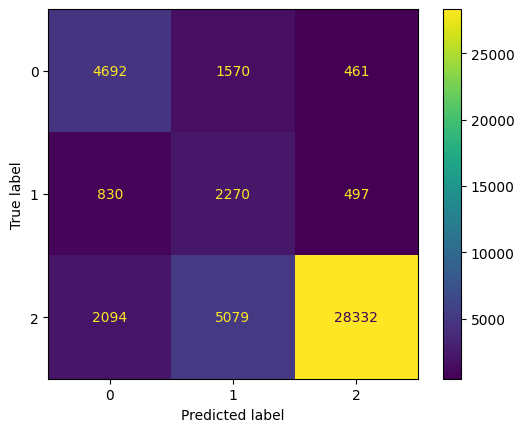

In [ ]:
predictions = NbClfTfIdf.predict(X_te_tf_idf_norm)
cm = confusion_matrix(y_test, predictions, labels=NbClfTfIdf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=NbClfTfIdf.classes_)
disp.plot()
plt.show()

##  Multinomial NB Word2Vec

In [ ]:
# Perform Hyperparameter Tuning Using RandomizedSearchCV

NbClfW2V = RandomizedSearchCV(nb, parameters, cv= cv_strat, return_train_score=True, random_state=35,refit=True,
                              n_jobs=-1,scoring="neg_log_loss", n_iter=13,verbose=2)

NbClfW2V.fit(X_tr_w2v_norm, y_tr_bal)

Fitting 15 folds for each of 13 candidates, totalling 195 fits


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=35),
                   estimator=MultinomialNB(class_prior=[0.33, 0.33, 0.33],
                                           force_alpha=False),
                   n_iter=13, n_jobs=-1,
                   param_distributions={'alpha': [1e-05, 0.0005, 0.0001, 0.005,
                                                  0.001, 0.05, 0.01, 0.1, 0.5,
                                                  1, 5, 10, 50, 100]},
                   random_state=35, return_train_score=True,
                   scoring='neg_log_loss', verbose=2)

In [ ]:
y_pred = NbClfW2V.predict_proba(X_te_w2v_norm)
log_loss(y_test,y_pred)

1.0881230254819445

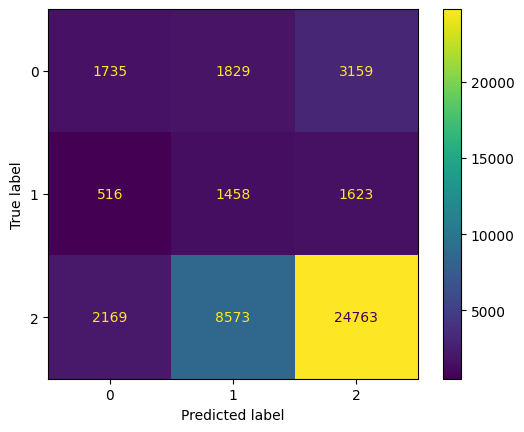

In [ ]:
predictions = NbClfW2V.predict(X_te_w2v_norm)
cm = confusion_matrix(y_test, predictions, labels=NbClfTfIdf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=NbClfTfIdf.classes_)
disp.plot()
plt.show()

##  Multinomial NB Avg Word2Vec

In [ ]:
# Perform Hyperparameter Tuning Using RandomizedSearchCV

NbClfAvgW2V = RandomizedSearchCV(nb, parameters, cv= cv_strat, return_train_score=True, random_state=35,refit=True,
                              n_jobs=-1,scoring="neg_log_loss", n_iter=13,verbose=2)

NbClfAvgW2V.fit(X_tr_avg_w2v_norm, y_tr_bal)

Fitting 15 folds for each of 13 candidates, totalling 195 fits


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=35),
                   estimator=MultinomialNB(class_prior=[0.33, 0.33, 0.33],
                                           force_alpha=False),
                   n_iter=13, n_jobs=-1,
                   param_distributions={'alpha': [1e-05, 0.0005, 0.0001, 0.005,
                                                  0.001, 0.05, 0.01, 0.1, 0.5,
                                                  1, 5, 10, 50, 100]},
                   random_state=35, return_train_score=True,
                   scoring='neg_log_loss', verbose=2)

In [ ]:
y_pred = NbClfAvgW2V.predict_proba(X_te_avg_w2v_norm)
log_loss(y_test,y_pred)

1.0347909758320362

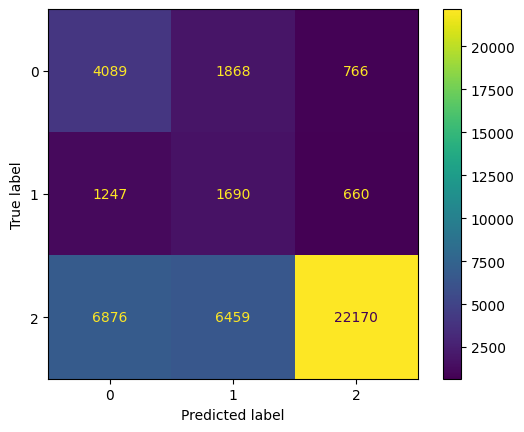

In [ ]:
predictions = NbClfAvgW2V.predict(X_te_avg_w2v_norm)
cm = confusion_matrix(y_test, predictions, labels=NbClfTfIdf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=NbClfTfIdf.classes_)
disp.plot()
plt.show()

##  Multinomial NB TFIDF weighted W2v

In [ ]:
# Perform Hyperparameter Tuning Using RandomizedSearchCV

NbClfTfIdfW2V = RandomizedSearchCV(nb, parameters, cv= cv_strat, return_train_score=True, random_state=35,refit=True,
                              n_jobs=-1,scoring="neg_log_loss", n_iter=10,verbose=2,error_score='raise')

NbClfTfIdfW2V.fit(X_tr_tfidf_w2v_norm, y_tr_bal)

Fitting 15 folds for each of 10 candidates, totalling 150 fits


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=35),
                   error_score='raise',
                   estimator=MultinomialNB(class_prior=[0.33, 0.33, 0.33],
                                           force_alpha=False),
                   n_jobs=-1,
                   param_distributions={'alpha': [1e-05, 0.0005, 0.0001, 0.005,
                                                  0.001, 0.05, 0.01, 0.1, 0.5,
                                                  1, 5, 10, 50, 100]},
                   random_state=35, return_train_score=True,
                   scoring='neg_log_loss', verbose=2)

In [ ]:
y_pred = NbClfTfIdfW2V.predict_proba(X_te_tfidf_w2v_norm)
log_loss(y_test,y_pred)

1.0680084732967163

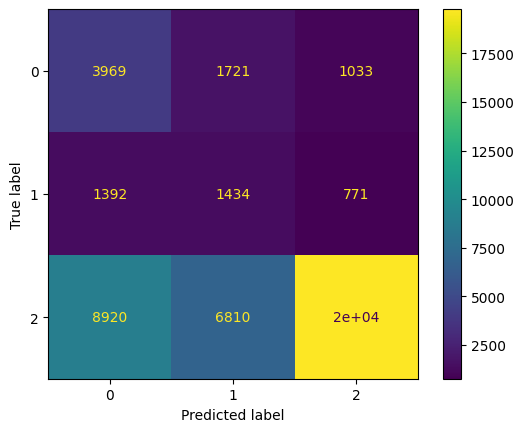

In [ ]:
predictions = NbClfTfIdfW2V.predict(X_te_tfidf_w2v_norm)
cm = confusion_matrix(y_test, predictions, labels=NbClfTfIdfW2V.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=NbClfTfIdfW2V.classes_)
disp.plot()
plt.show()

In [3]:
# Specify the Column Names while initializing the Table

evaluation_table = PrettyTable(["Vectorization Methods with Naive Bayes", "Log Loss"])

# adding rows
evaluation_table.add_row(["Random Model",0.69])
evaluation_table.add_row(["Bag Of Words(BOW)",0.74])
evaluation_table.add_row(["Bi,Tri Gram BOW",0.63])
evaluation_table.add_row(["Binary BOW",0.85])
evaluation_table.add_row(["TF-IDF",0.58])
evaluation_table.add_row(["Word2Vec(W2V)",1.08])
evaluation_table.add_row(["Avg W2V",1.03])
evaluation_table.add_row(["Tf-Idf W2V",1.06])

#Print
print(evaluation_table)

+----------------------------------------+----------+
| Vectorization Methods with Naive Bayes | Log Loss |
+----------------------------------------+----------+
|              Random Model              |   0.69   |
|           Bag Of Words(BOW)            |   0.74   |
|            Bi,Tri Gram BOW             |   0.63   |
|               Binary BOW               |   0.85   |
|                 TF-IDF                 |   0.58   |
|             Word2Vec(W2V)              |   1.08   |
|                Avg W2V                 |   1.03   |
|               Tf-Idf W2V               |   1.06   |
+----------------------------------------+----------+


# Modelling Observation

* MultiClass log loss is least for Tf-Idf vectorizer.
* Tf-Idf log loass is 14% less than the loss for random model prediction.
* All other models loss is greater than random model loss.
* Choosing TF-IDF as the final model.

# **Summary**

* Data is highly imbalanced and after target feature transformation,
* Positve class was more than twice of neutral and negative.
* Performed both Underampling and over sampling to balance the samples of median distribution.
* Combined both sumary and text feature for cleaning and vectorization.
* As read in theory Tf-Idf out performed other vectorization methods.
* Naive bayese clssifier is used with Tf-Idf since its fast even with high dimension data.
* Lowest log loss is 0.59.

# Deployment
* Save required models,variables for deployment.

**Save Vectorizer**

In [ ]:
# Open a file and use dump()
with open('/content/drive/MyDrive/DS_DL_ML_AI_project/Sentiment Analysis/text_vectorizer.pkl', 'wb') as file_vect:
      
    # A new file will be created
    pickle.dump(tf_idf_vect, file_vect)

**Save Normalizer**

In [ ]:
# Open file where you want to store
with open('/content/drive/MyDrive/DS_DL_ML_AI_project/Sentiment Analysis/text_normalizer.pkl','wb') as file_norm:
  
  # Dump info to that file
  pickle.dump(tfIdf_norm,file_norm)

**Save Model**

In [ ]:
with open('/content/drive/MyDrive/DS_DL_ML_AI_project/Sentiment Analysis/sentimentAnalysis_model.pkl','wb') as file_model:
  # Dump info to that file
  pickle.dump(NbClfTfIdf,file_model)

# Conclusion
* Even though the least log loass is 0.58 with Naive Bayese and Tf-Idf there is still huge missclassification.
* To decrease log loss we can try with other classification algorithms with Tf-Idf vectorizatino.